# We Rate Dogs: An Analysis of Twitter’s Most Popular Dog Rating Account

## Table of Contents
1. [Data Gathering](#gathering)
2. [Assessing Data](#assessing)
3. [Cleaning Data](#cleaning)
4. [Storing Data](#storing)
5. [Analyzing and Visualizing Data](#visualizing)


<a id=gathering></a>
## Data Gathering
This involves gathering **all** three pieces of data for this project using different methods and loading them in the notebook.


In [1]:
import warnings# to ignore all unnecessary warnings
warnings.filterwarnings("ignore")

#import all necessary libraries
import tweepy as tw
import numpy as np
import pandas as pd
import requests
import json
import os
import time
import glob
import re

#Visualization libraries
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# WordCloud - Python library for creating image wordclouds
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS


#Natural Language Processing ToolKit
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt') #for tokenising sentences
nltk.download('averaged_perceptron_tagger') #For tagging words with their parts of speech (POS)
from nltk.corpus import stopwords #get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize,sent_tokenize # to create word tokens
from collections import Counter #to help count individual words

#For opening, manipulating, and saving many different image files
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
#Manually upload a file on hand into a pandas data frame
archives_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#Now let's check if the file was imported correctly
archives_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
#To check number of rows and columns
archives_df.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
#To programatically download a file from the Udacity servers using requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [6]:
#To access the body of the response
with open (os.path.join(url.split('/')[-1]), mode = 'wb') as file:
          file.write(response.content)

predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [7]:
#To check if the file was stored properly
predictions_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [8]:
#To get a general idea of the number of entries in this data frame
predictions_df.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
#Twitter keys (delete before uploading project)
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
#The latest version of tweepy removed the 'wait_on_rate_limit_notify' parameter and returns an error
api = tw.API(auth, wait_on_rate_limit=True)

In [10]:
#get a list of tweet ids to use for downloading the Twitter API
tweet_IDs = archives_df.tweet_id.values
len(tweet_IDs)

2356

In [15]:
#To query Twitter's API for JSON data for each tweet ID in the data frame
count = 0
fails_dict = {}
start = time.time()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_IDs:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tw.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = time.time()
print(end - start)
print(fails_dict)
print('This block of code took', end - start, 'to run')

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [16]:
#To read file line by line and create a list of dictionaries
tweet_list = []
file_name = 'tweet_json.txt'
with open(file_name, encoding='utf-8') as file:
        for data in file:
            data = json.loads(data)
            tweet_id = data['id']
            retweet_count = data['retweet_count']
            favorite_count = data['favorite_count']
            tweet_list.append({'tweet_id': int(tweet_id),
                               'retweet_count': int(retweet_count),
                               'favorite_count': int(favorite_count)})
        
#We'll now convert the list of dictionaries to a pandas DataFrame
            json_tweets = pd. DataFrame(tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [17]:
#To check the tweet dataframe
json_tweets.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33695
1,892177421306343426,5272,29218


Gathering of data is now complete.

<a id=assessing></a>
## Assessing Data
This section covers detection and documentation of at least **eight (8) quality issues and two (2) tidiness issue** using **both** visual assessment and programmatic assessement to assess the data.

**Note:** The following key points were considered when assessing the data.
1. Only original ratings (no retweets) that have images are required
2. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
3. Only required to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
4. The fact that the rating numerators are greater than the denominators is not material since it is a big part of the popularity of WeRateDogs.
5. Tweets beyond August 1st, 2017 were not needed as the algorithm used to gather the image predictions for these tweets was not accesible for this project


### Assessing the twitter-archived-enhanced dataset (archives_df)

In [18]:
#Load the three data frames to assess the data visually and programatically
archives_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [19]:
archives_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [20]:
#To get a quick glance of column names and data types
archives_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Findings: 
1. Programmatic and visual assessment shows that the columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` appear to have several missing values
2. Visual assessment shows **78** tweets are actually replies and  **181** tweets are retweets.
3. Visual assessment also shows four columns doggo, floofer, pupper and puppo which should be values not variables.
4. Timestamp is data type string note datetime
5. Visual assessment shows innacurate values captured in the name section

In [21]:
#To get the value counts for each name
name_counts = archives_df['name'].value_counts()
print(name_counts)

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64


In [22]:
#To get the value counts for each rating_denominator
rating_denominator_counts = archives_df['rating_denominator'].value_counts()
rating_denominator_counts

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [23]:
#To get the value counts for each rating_numerator
rating_numerator_counts = archives_df['rating_numerator'].value_counts()
rating_numerator_counts

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [24]:
#To check for duplicates in the column source
sum(archives_df.source.duplicated())

2352

### Assessing the image-prediction dataset (predictions)

In [25]:
predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


**NOTE**
1. **p1** is the algorithm's #1 prediction for the image in the tweet → golden retriever
2. **p1_conf** is how confident the algorithm is in its #1 prediction 
3. **p1_dog** is whether or not the #1 prediction is a breed of dog
4. **p2** is the algorithm's second most likely prediction → Labrador retriever
5. **p2_conf** is how confident the algorithm is in its #2 prediction 
6. **p2_dog** is whether or not the #2 prediction is a breed of dog 
7. **p3** is the algorithm's third most likely prediction 
8. **p2_conf** is how confident the algorithm is in its #2 prediction
9. **p2_dog** is whether or not the #2 prediction is a breed of dog  


In [26]:
#To programmatically assess the tidyness of the dataframe
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
#To view a random sample of the daraframe
predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1046,713175907180089344,https://pbs.twimg.com/media/CeW1tERWAAAA9Q2.jpg,1,timber_wolf,0.503788,False,malamute,0.430624,True,Siberian_husky,0.028454,True
843,695064344191721472,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False
1149,731285275100512256,https://pbs.twimg.com/media/CiYME3tVAAENz99.jpg,1,Pembroke,0.967103,True,Cardigan,0.021126,True,Chihuahua,0.002231,True
2015,879492040517615616,https://pbs.twimg.com/media/DDSVWMvXsAEgmMK.jpg,1,German_short-haired_pointer,0.479896,True,vizsla,0.124353,True,bath_towel,0.073320,False
220,670086499208155136,https://pbs.twimg.com/media/CUygHhFXAAAwNXv.jpg,1,German_short-haired_pointer,0.273492,True,Staffordshire_bullterrier,0.132944,True,bluetick,0.124562,True


In [28]:
#to check for missing values in the predictions dataframe
predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [29]:
#to check for duplicates in the breeds dataframe
predictions_df[predictions_df.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [30]:
#To check for tweets which do not display dogs
false_p = predictions_df.query("p1_dog == False and p2_dog == False and p3_dog == False")
false_p

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


### Assessing the data set extracted via twitter API (json_tweets)

In [31]:
json_tweets

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33695
1,892177421306343426,5272,29218
2,891815181378084864,3464,21973
3,891689557279858688,7191,36782
4,891327558926688256,7715,35179
...,...,...,...
2274,666049248165822465,36,88
2275,666044226329800704,115,246
2276,666033412701032449,36,100
2277,666029285002620928,39,112


In [32]:
#To programmatically assess column names and data types
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2279 entries, 0 to 2278
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2279 non-null   int64
 1   retweet_count   2279 non-null   int64
 2   favorite_count  2279 non-null   int64
dtypes: int64(3)
memory usage: 53.5 KB


In [33]:
# To get the total number of tweets that have zero as the 
zero_favorite_count = json_tweets[
    json_tweets['favorite_count'] == 0
]
sum(zero_favorite_count.value_counts())

159

In [34]:
#To check for duplicates 
json_tweets[json_tweets.duplicated()]

,tweet_id,retweet_count,favorite_count


In [35]:
#To check for missing data in the api data frame
json_tweets.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [36]:
#To find duplicate column names in the three tables using pandas
all_columns = pd.Series(list(archives_df) 
                        + list(predictions_df) 
                        + list(json_tweets))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

The following issues were identified following visual and programmatic assessment.

### Quality issues
1. **Validity**: Some tweet_ids represent retweets and not original tweets - **twitter-archive-enhanced dataframe**

2. Some tweet_ids represent replies and not original tweets- **twitter-archive-enhanced dataframe**

3. Name column in **twitter-archive-enhanced dataframe** contains inaccurate values (e.g. a, none)

4. The text column of the **twitter-archive-enhanced dataframe** contains both tweets and tweet url

5. The **twitter-archive-enhanced dataframe** expanded url column contains the same information as the url substring in the text url

6. The **twitter-archive-enhanced dataframe** source column contains the actual source and html code

7. Timestamp column in  **twitter-archive-enhanced dataframe** is in string format

8. Non-descriptive column names in the twitter-archive-enhanced and image-predictions dataframes

### Tidiness issues
1. Dog Prediction, Confidence level and Breeds are contained in three different columns. 324 rows are predicted false, not related to dogs.

2. Data describing age/stage of the dogs (doggo, flooffer, pupper, puppo) contained in different columns in twitter-archive-enhanced dataframe
3. The data is contained in 3 different tables with duplicated column names

<a id=cleaning></a>
## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [37]:
# Make copies of original pieces of data
archives_clean = archives_df.copy()
predictions_clean = predictions_df.copy()
twitterapi_clean = json_tweets.copy()

In [38]:
archives_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [39]:
predictions_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [40]:
twitterapi_clean.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33695
1,892177421306343426,5272,29218


### Issue #1 & #2: Some tweet ids represent retweets and replies and not original tweets in the twitter-archive-enhanced dataframe

#### Define

Remove all rows containing retweets and replies where the columns are non-null then drop the columns from the dataframe.

#### Code

In [41]:
#To remove all retweets entries from the dataframe
archives_clean = archives_clean[
    archives_clean.retweeted_status_id.isnull()]

#To remove all reply entries from the dataframe
archives_clean = archives_clean[
    archives_clean.in_reply_to_status_id.isnull()]

# To drop columns not needed for analysis
archives_clean.drop(["in_reply_to_status_id", "in_reply_to_user_id", 
                     "retweeted_status_id", "retweeted_status_user_id", 
                     "retweeted_status_timestamp"], inplace=True, axis=1)

#### Test

In [42]:
#confirm if the rows were dropped should return 259(181 retweets & 79 replies)
print('The number of rows dropped:', archives_df.shape[0] - archives_clean.shape[0])
#confirm if the columns were dropped
list(archives_clean)

The number of rows dropped: 259


['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Issue #3: Name column in **twitter-archive-enhanced dataframe** contains inaccurate values (e.g. a, none) 

#### Define

Correct all the names with values that are not names. These are mostly values that are lowercase which will be replaced by a string 'None'


#### Code

In [43]:
pattern = '^[a-z]'  #create a regex pattern for the false names which are all lower case letters

false_names = archives_clean.name.str.contains(pattern, regex=True)  #find all false names in the column 

#To sort the value count for all false names by index
false_names_count = archives_clean[false_names].name.value_counts().sort_index()

#To edit only the subset of the dataframe with false names
archives_clean.loc[false_names, 'name'] = "None"

#### Test

In [44]:
#To check if the changes were effected
print('A sample of the value counts after cleaning:\n', archives_clean['name'].sample(10))

A sample of the value counts after cleaning:
 158        Burt
157        None
1989      Jerry
1186       None
1050      Kayla
1556       Brad
2175    Jaspers
679          Bo
1667       Joey
982        None
Name: name, dtype: object


### Issue #4: The text column of the **twitter-archive-enhanced dataframe** contains both tweets and tweet url

#### Define

Extract the actual tweet and the url from the text column using index slicing. Drop the text column when done.

#### Code

In [45]:
archives_clean['text'].str[-23:]  #To extract the tail of the text using slicing

archives_clean['tweet_urls'] = archives_clean['text'].str[-23:]  #add the extracted urls as a new column

tweets = archives_clean['text'].str[:-23]  #To extract the head of the tweet using slicing

archives_clean['actual_tweets'] = archives_clean['text'].str[:-23]  #add the extracted tweets as a new column 

archives_clean.drop(['text'], axis = 1, inplace = True)  #To drop the text column

#### Test

In [46]:
print('The new columns are:\n', list(archives_clean))

archives_clean.sample(5)

The new columns are:
 ['tweet_id', 'timestamp', 'source', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 'tweet_urls', 'actual_tweets']


,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,tweet_urls,actual_tweets
1665,682750546109968385,2016-01-01 02:29:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/682750546...,9,10,Taco,None,None,None,None,https://t.co/85X1GHohFr,Meet Taco. He's a speckled Garnier Fructis. Lo...
1554,688898160958271489,2016-01-18 01:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/688898160...,10,10,None,None,None,None,None,https://t.co/MfEaMUFYTx,When you have a ton of work to do but then rem...
1652,683481228088049664,2016-01-03 02:53:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/683481228...,11,10,Banjo,None,None,pupper,None,https://t.co/H7NZFumpKq,Meet Banjo. He's a Peppercorn Shoop Da Whoop. ...
1433,697463031882764288,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None,https://t.co/HppvrYuamZ,Happy Wednesday here's a bucket of pups. 44/40...
433,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None,https://t.co/NIYC820tmd,The floofs have been released I repeat the flo...


### Issue #5: The **twitter-archive-enhanced dataframe** expanded url column contains the same information as the url substring in the text url

#### Define

Drop the `expanded_url` column since it contains more missing values, more duplicates and does not look as neat as the `tweet_urls` column created in the previous step.

#### Code

In [47]:
#To drop the column
archives_clean.drop(["expanded_urls"], inplace=True, axis=1)

#### Test

In [48]:
#To check if the column was dropped
list(archives_clean)

['tweet_id',
 'timestamp',
 'source',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'tweet_urls',
 'actual_tweets']

### Issue #6: The **twitter-archive-enhanced dataframe** source column contains the actual source and html code 

#### Define

Extract the string between `<a href="">` and `<a>` to leave only the source using regular expressions and pandas' `str.extract` method.

#### Code

In [49]:
#To view the source column
archives_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [50]:
#Creating a regular expression for the html code
pattern = '^<a.+>(.+)</a>$'
#Extract the html code and leave everything else
archives_clean['source'] = archives_clean['source'].str.extract(pattern)

#### Test

In [51]:
#To check if it worked
archives_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Issue #7: Timestamp column in  **twitter-archive-enhanced dataframe** is a string

#### Define

Change the `timestamp` column data types from object to datetime. 

#### Code

In [52]:
#convert the dates and floor
archives_clean['timestamp'] = pd.to_datetime(archives_clean.timestamp).dt.floor(freq='S')

#### Test

In [53]:
print('The new data types are:\n', archives_clean.dtypes)

The new data types are:
 tweet_id                            int64
timestamp             datetime64[ns, UTC]
source                             object
rating_numerator                    int64
rating_denominator                  int64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
tweet_urls                         object
actual_tweets                      object
dtype: object


### Issue #8: Non-descriptive column names in the twitter-archive-enhanced and image-predictions dataframes

#### Define

The column names `p1`,`p1_dog`,`p1_conf`, `p2`,`p2_dog`,`p2_conf`, `p3`,`p3_dog`,`p3_conf` in the archive dataframe and column names `doggo`, `floofer`, `pupper`, `puppo` in image-prediction are not very easy to understand. These will be addressed when tackling issues number 9 and 10.

###  Issue #9(Tidiness): Dog Prediction, Confidence level and Breeds are contained in three different columns. 324 rows are predicted false, not related to dogs.

#### Define

Combine the columns so that each variable is in its own column and drop rows with false predictions.
This will be a two step process:
1. Create two new columns, `breed` and `confidence_level`. Using `numpy.select()`function, go through all the dog predictions (p1_dog,p2_dog and p3_dog) identify the breed with the highest confidence level and input that into the new `breed` column. The `confidence_level` column will hold the highest confidence level identified.
2. For each of the 324 rows that do not contain tweets about dogs, set `breed` to none and `confidence_level` to zero and then drop the duplicate columns `p1`,`p1_dog`,`p1_conf`, `p2`,`p2_dog`,`p2_conf`, `p3`,`p3_dog`,`p3_conf`

**NOTE**: This will also address the eigth issue of non-descriptive column names

#### Code

In [54]:
#Create the condition that dog prediction needs to be true
condition = [(predictions_clean['p1_dog'] == True), 
             (predictions_clean['p2_dog'] == True), 
             (predictions_clean['p3_dog'] == True),]
#Create choice list in order of priority for breed
choice_breed = [predictions_clean['p1'], 
                predictions_clean['p2'], 
                predictions_clean['p3']]
#Create choice list in order of priority for confidence level
choice_confidence = [predictions_clean['p1_conf'], 
                    predictions_clean['p2_conf'], 
                    predictions_clean['p3_conf']]
#select the predicted breed based on the first successful condition
predictions_clean['breed'] = np.select(condition, choice_breed, default='')

#select the predicted confidence level based on the first successful condition
predictions_clean['confidence_level'] = np.select(condition, choice_confidence, default='')

#### Test

In [55]:
predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,basset,0.555712
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,Labrador_retriever,0.1680859999999999
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua,0.716012
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,0.323581


#### Code -Part 2

In [56]:
#We can now adjust the confidence levels and prediction for the 324 rows
#Replace confidence level
predictions_clean.confidence_level=predictions_clean.confidence_level.replace('', '0')
#replace breed
predictions_clean.breed=predictions_clean.breed.replace('', 'None')
#Drop the numerous columns indicating dog, breed, and confidence levels
predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

In [57]:
#Replace underscore separating breed names and put them in title case
predictions_clean.breed=predictions_clean.breed.replace('_', ' ')
predictions_clean.breed=predictions_clean.breed.str.title()
#Change the data types of tweet id, breed and confidence level
predictions_clean['tweet_id'] = predictions_clean['tweet_id'].fillna(0) #convertnull/NaN to zero
predictions_clean['tweet_id']=predictions_clean['tweet_id'].astype('int64')
predictions_clean['breed']=predictions_clean['breed'].astype('category')
predictions_clean['confidence_level']=predictions_clean['confidence_level'].astype('float64')
#When adding the confidence level column, it seems an extra row was added at the end of the data set. We need to drop the row
predictions_clean.drop(predictions_clean.index[-1], inplace=True)

#### Test -Part 2

In [58]:
#Check for changes in confidence level and breed values
predictions_clean.sample(5)

,tweet_id,jpg_url,img_num,breed,confidence_level
883,698907974262222848,https://pbs.twimg.com/media/CbMFFssWIAAyuOd.jpg,3,German_Short-Haired_Pointer,0.983131
1698,816816676327063552,https://pbs.twimg.com/media/C1XqbhXXUAElpfI.jpg,1,Malamute,0.668164
639,681297372102656000,https://pbs.twimg.com/media/CXR0WJ_W8AMd_O8.jpg,1,Lhasa,0.482401
776,689661964914655233,https://pbs.twimg.com/media/CZIr5gFUsAAvnif.jpg,1,Italian_Greyhound,0.322818
1657,810896069567610880,https://pbs.twimg.com/media/C0DhpcrUAAAnx88.jpg,1,Flat-Coated_Retriever,0.820804


In [59]:
#Check for changes in data types and breed
predictions_clean.tail(5)

,tweet_id,jpg_url,img_num,breed,confidence_level
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_Retriever,0.425595
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_Retriever,0.168086
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581


In [60]:
#check if last row was dropped
predictions_clean.tail(5)

,tweet_id,jpg_url,img_num,breed,confidence_level
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_Retriever,0.425595
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_Retriever,0.168086
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581


### Issue #10:Data describing age/stage of the dogs (doggo, flooffer, pupper, puppo) contained in different columns in **twitter-archive-enhanced dataframe**

#### Define

Column names `doggo`, `floofer`, `pupper`, `puppo` are actually values belonging to a variable 'dog phase'. To clean this up, merge the four into a new column.

#### Code

In [61]:
# Create 'dog_phase' variable which is made by extracting from the individual dog phases columns
#Create the condition
condition = [(archives_clean['pupper'] == "pupper"), 
             (archives_clean['doggo'] == "doggo"), 
             (archives_clean['floofer'] == "floofer"),
             (archives_clean['puppo'] == "puppo")]
#Create choice list in order of priority for stage
choice_list = [archives_clean['pupper'], 
                archives_clean['doggo'], 
                archives_clean['floofer'],
                archives_clean['puppo']]

#select the predicted breed based on the first successful condition
archives_clean['dog_phase'] = np.select(condition, choice_list, default='none')
#Drop the individual dog phase columns
columns_to_drop = ['doggo', 'floofer', 'pupper', 'puppo']
archives_clean.drop(columns_to_drop, axis = 1, inplace = True)

#### Test

In [62]:
#test if the dog_phase column was created and populated
archives_clean.sample(5)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,tweet_urls,actual_tweets,dog_phase
1036,744971049620602880,2016-06-20 19:11:53+00:00,Twitter for iPhone,12,10,Indie,https://t.co/KgSEkrPA3r,Say hello to Indie and Jupiter. They're having...,none
143,864197398364647424,2017-05-15 19:14:50+00:00,Twitter for iPhone,13,10,Paisley,https://t.co/cPq9fYvkzr,This is Paisley. She ate a flower just to prov...,none
1925,674063288070742018,2015-12-08 03:09:46+00:00,Twitter for iPhone,5,10,Earl,https://t.co/1ZbfqAVDg6,This is Earl. Earl is lost. Someone help Earl....,none
1521,690690673629138944,2016-01-23 00:21:03+00:00,Twitter for iPhone,10,10,Cedrick,https://t.co/yS7T4gxKod,This is Cedrick. He's a spookster. Did me a di...,none
2091,670783437142401025,2015-11-29 01:56:48+00:00,Twitter for iPhone,1,10,None,https://t.co/jxukeh2BeO,Flamboyant pup here. Probably poisonous. Won't...,none


In [63]:
#check if columns have been dropped
archives_clean.sample(5)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,tweet_urls,actual_tweets,dog_phase
712,784431430411685888,2016-10-07 16:33:21+00:00,Twitter for iPhone,12,10,Stormy,https://t.co/PHA1vtqqpt,This is Stormy. He's curly af. Already pupared...,none
1664,682788441537560576,2016-01-01 05:00:24+00:00,Twitter for iPhone,12,10,None,https://t.co/ZSdEj59FGf,Happy New Year from your fav holiday squad! 🎉 ...,pupper
2082,670815497391357952,2015-11-29 04:04:12+00:00,Twitter for iPhone,10,10,Sage,https://t.co/nLYruSMRe6,This is Sage. He likes to burn shit. 10/10,none
1137,728046963732717569,2016-05-05 02:21:37+00:00,Twitter for iPhone,11,10,Raymond,https://t.co/9aMxSbOaAZ,This is Raymond. He controls fountains with hi...,none
1766,678399652199309312,2015-12-20 02:20:55+00:00,Twitter for iPhone,12,10,None,https://t.co/VRTbo3aAcm,This made my day. 12/10 please enjoy,none


### Issue #11(Tidiness):The data is contained in 3 different tables with duplicated column names

#### Define

Merge the three dataframes to make analysing and visualizing the data easier

#### Code

In [64]:
#merge the three data sets and reorder the columns
df_merged = archives_clean.merge(predictions_clean,on='tweet_id').merge(twitterapi_clean,on='tweet_id')
#reorder the columns to preference
df_cleaned =df_merged.reindex(columns= ['tweet_id', 'actual_tweets', 'retweet_count', 'favorite_count', 'timestamp', 'breed', 'confidence_level', 'name', 'dog_phase',
 'rating_numerator', 'rating_denominator','source', 'tweet_urls','jpg_url', 'img_num'])
#change the dog phase data type to category
df_cleaned['dog_phase']=df_cleaned['dog_phase'].astype('category')

#### Test

In [65]:
df_merged.sample(5)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,tweet_urls,actual_tweets,dog_phase,jpg_url,img_num,breed,confidence_level,retweet_count,favorite_count
1659,670782429121134593,2015-11-29 01:52:48+00:00,Twitter for iPhone,5,10,None,https://t.co/6dioUL6gcP,This dude slaps your girl's ass what do you do...,none,https://pbs.twimg.com/media/CU8ZDu9WwAADg3N.jpg,1,Chihuahua,0.952963,654,1345
99,868622495443632128,2017-05-28 00:18:35+00:00,Twitter for iPhone,13,10,None,https://t.co/yeaH8Ej5eM,Here's a h*ckin peaceful boy. Unbothered by th...,none,https://pbs.twimg.com/media/DA33i0XXsAEQtCA.jpg,1,Labrador_Retriever,0.868107,4443,23567
1355,678767140346941444,2015-12-21 02:41:11+00:00,Twitter for iPhone,8,10,Mia,https://t.co/G6TQVgTcZz,This is Mia. She makes awful decisions. 8/10,none,https://pbs.twimg.com/media/CWt3G6EVEAIGEPr.jpg,1,None,0.000000,1222,3214
1308,680970795137544192,2015-12-27 04:37:44+00:00,Twitter for iPhone,9,10,None,https://t.co/CXSJZ4Stk3,I thought I made this very clear. We only rate...,none,https://pbs.twimg.com/media/CXNLU6wWkAE0OkJ.jpg,1,Pug,0.713102,583,2203
1053,699691744225525762,2016-02-16 20:28:06+00:00,Twitter for iPhone,5,10,Dave,https://t.co/ZJnCxlIf62,This is Dave. He's a tropical pup. Short lil l...,none,https://pbs.twimg.com/media/CbXN7aPWIAE0Xt1.jpg,1,None,0.000000,4147,9434


In [66]:
#check the new column order
df_cleaned.head(2)

,tweet_id,actual_tweets,retweet_count,favorite_count,timestamp,breed,confidence_level,name,dog_phase,rating_numerator,rating_denominator,source,tweet_urls,jpg_url,img_num
0,892177421306343426,This is Tilly. She's just checking pup on you....,5272,29218,2017-08-01 00:17:27+00:00,Chihuahua,0.323581,Tilly,none,13,10,Twitter for iPhone,https://t.co/0Xxu71qeIV,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
1,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3464,21973,2017-07-31 00:18:03+00:00,Chihuahua,0.716012,Archie,none,12,10,Twitter for iPhone,https://t.co/wUnZnhtVJB,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1


In [67]:
#confirm data types and info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916 entries, 0 to 1915
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1916 non-null   int64              
 1   actual_tweets       1916 non-null   object             
 2   retweet_count       1916 non-null   int64              
 3   favorite_count      1916 non-null   int64              
 4   timestamp           1916 non-null   datetime64[ns, UTC]
 5   breed               1916 non-null   category           
 6   confidence_level    1916 non-null   float64            
 7   name                1916 non-null   object             
 8   dog_phase           1916 non-null   category           
 9   rating_numerator    1916 non-null   int64              
 10  rating_denominator  1916 non-null   int64              
 11  source              1916 non-null   object             
 12  tweet_urls          1916 non-null 

<a id=storing></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [68]:
#save the master dataset to csv file
df_cleaned.to_csv('twitter_archive_master.csv', index=False)

<a id=visualizing></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### What is the Correlation between the variables?

In [69]:
#To find the relationship between the variables
df_cleaned.corr()

,tweet_id,retweet_count,favorite_count,confidence_level,rating_numerator,rating_denominator,img_num
tweet_id,1.000000,0.385384,0.612723,0.147509,0.024558,-0.017755,0.215069
retweet_count,0.385384,1.000000,0.928927,0.033370,0.019095,-0.017499,0.103495
favorite_count,0.612723,0.928927,1.000000,0.077107,0.016485,-0.024610,0.130836
confidence_level,0.147509,0.033370,0.077107,1.000000,-0.023171,0.000071,0.146949
rating_numerator,0.024558,0.019095,0.016485,-0.023171,1.000000,0.185661,-0.003353
rating_denominator,-0.017755,-0.017499,-0.024610,0.000071,0.185661,1.000000,-0.017005
img_num,0.215069,0.103495,0.130836,0.146949,-0.003353,-0.017005,1.000000


**Findings**

    1. There appears to be a very strong correlation between the retweet count and the favorite count
    2. There appears to be a very low correlation between rating numerator and rating denominator and all other variables
    3. The variables image number, retweet count and favorite count appear to have a negative correlation with the rating denominator

### What is the relationship between Favorite Count, Retweet Count and Dog Predictions?

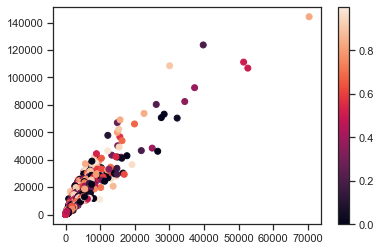

In [70]:
#To investigate the relationship between the favorite count, retweet count and dog predictions
plt.scatter(data = df_cleaned, x = 'retweet_count', y = 'favorite_count', c = 'confidence_level');
plt.colorbar()

Finding: There is a positive correlation between favorite count, retweet count and confidence_level

### Which was the most liked tweet?

In [71]:
most_liked = df_cleaned[df_cleaned.favorite_count == df_cleaned.favorite_count.max()]
most_liked

,tweet_id,actual_tweets,retweet_count,favorite_count,timestamp,breed,confidence_level,name,dog_phase,rating_numerator,rating_denominator,source,tweet_urls,jpg_url,img_num
740,744234799360020481,Here's a doggo realizing you can stand in a po...,70326,144244,2016-06-18 18:26:18+00:00,Labrador_Retriever,0.825333,None,doggo,13,10,Twitter for iPhone,https://t.co/7wE9LTEXC4,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1


### Which tweet has the highest retweets?

In [72]:
most_retweeted = df_cleaned[df_cleaned.retweet_count 
                            == df_cleaned.retweet_count.max()]
most_retweeted

,tweet_id,actual_tweets,retweet_count,favorite_count,timestamp,breed,confidence_level,name,dog_phase,rating_numerator,rating_denominator,source,tweet_urls,jpg_url,img_num
740,744234799360020481,Here's a doggo realizing you can stand in a po...,70326,144244,2016-06-18 18:26:18+00:00,Labrador_Retriever,0.825333,None,doggo,13,10,Twitter for iPhone,https://t.co/7wE9LTEXC4,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1


In [73]:
list(most_retweeted.actual_tweets)

["Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) "]

From the findings above, there appears not to be a very strong correlation among the numerical variables except for confidence level, likes and retweets. To further investigate the non-numerical data, I decided to do two things:
1. Investigate the actual tweets and find the most used words and their frequencies using the wordcloud library; and
2. Create a visualization in Tableau Public

In [74]:
#Let's start formatting the actual_tweets column in order to create a wordcloud
pd.set_option('display.max_colwidth', None) 
df_cleaned[['actual_tweets']]

,actual_tweets
0,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10"
1,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
2,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
3,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek"
4,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
...,...
1911,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10
1912,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10
1913,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af
1914,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of


In [75]:
#Create a regex to remove all punctuation and characters that are not text
df_cleaned['actual_tweets'] = df_cleaned['actual_tweets'].str.replace(r"[^a-zA-Z ]+", " ").str.strip()
#Make all words lower case for easier analysis
df_cleaned['actual_tweets'] = df_cleaned['actual_tweets'].str.lower()
#To check if it worked
df_cleaned[['actual_tweets']]

,actual_tweets
0,this is tilly she s just checking pup on you hopes you re doing ok if not she s available for pats snugs boops the whole bit
1,this is archie he is a rare norwegian pouncing corgo lives in the tall grass you never know when one may strike
2,this is darla she commenced a snooze mid meal happens to the best of us
3,this is franklin he would like you to stop calling him cute he is a very fierce shark and should be respected as such barkweek
4,here we have a majestic great white breaching off south africa s coast absolutely h ckin breathtaking ig tucker marlo barkweek
...,...
1911,here we have a st generation vulpix enjoys sweat tea and fox news cannot be phased
1912,this is a purebred piers morgan loves to netflix and chill always looks like he forgot to unplug the iron
1913,here is a very happy pup big fan of well maintained decks just look at that tongue would cuddle af
1914,this is a western brown mitsubishi terrier upset about leaf actually dogs here would walk the shit out of


In [76]:
#Let's combine all tweets into one big text for easier analysis
text = " ".join(tweet for tweet in df_cleaned.actual_tweets)

#Tokenize the text i.e split the sentences into words
word_tokenize(text)

print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 180821 words in the combination of all tweets.


In [77]:
#Apply Named Entity Recognition (NER) to identify each word's entity
text_tag = word_tokenize(text)
nltk.pos_tag(text_tag)

[('this', 'DT'),
 ('is', 'VBZ'),
 ('tilly', 'RB'),
 ('she', 'PRP'),
 ('s', 'VBZ'),
 ('just', 'RB'),
 ('checking', 'VBG'),
 ('pup', 'NN'),
 ('on', 'IN'),
 ('you', 'PRP'),
 ('hopes', 'VBP'),
 ('you', 'PRP'),
 ('re', 'VBP'),
 ('doing', 'VBG'),
 ('ok', 'NN'),
 ('if', 'IN'),
 ('not', 'RB'),
 ('she', 'PRP'),
 ('s', 'VBZ'),
 ('available', 'JJ'),
 ('for', 'IN'),
 ('pats', 'NNS'),
 ('snugs', 'VBP'),
 ('boops', 'IN'),
 ('the', 'DT'),
 ('whole', 'JJ'),
 ('bit', 'NN'),
 ('this', 'DT'),
 ('is', 'VBZ'),
 ('archie', 'JJ'),
 ('he', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('rare', 'JJ'),
 ('norwegian', 'JJ'),
 ('pouncing', 'VBG'),
 ('corgo', 'NN'),
 ('lives', 'NNS'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('tall', 'JJ'),
 ('grass', 'NN'),
 ('you', 'PRP'),
 ('never', 'RB'),
 ('know', 'VBP'),
 ('when', 'WRB'),
 ('one', 'CD'),
 ('may', 'MD'),
 ('strike', 'VB'),
 ('this', 'DT'),
 ('is', 'VBZ'),
 ('darla', 'JJ'),
 ('she', 'PRP'),
 ('commenced', 'VBD'),
 ('a', 'DT'),
 ('snooze', 'NN'),
 ('mid', 'NN'),
 ('meal', 'NN'

In [78]:
#https://www.datacamp.com/tutorial/wordcloud-python
# Create stopword list to store all words that are not needed in analysis including user-defined stop words 
stoplist = set(stopwords.words('english'))
for w in text:
    if w not in stoplist:
        pass
stoplist.update(["may", "h", "ckin", "hello", "tho", 
                 "will", "ck", "say", "meet", "like", 
                 "one", "got", "get", "want", "please",
                 "really", "than", "af", "now",  "well",
                 "re", "co", "know", "still", "much", 
                 "look", "ll", "need", "thank", "must", 
                 "see", "rather", "named", "wants", 
                 "day", "looks", "m", "trying", "ve", 
                 "https", "going", "always", "quite", 
                 "stop", "sending", "send", "name", 
                 "absolutely", "extremely", "would", 
                 "help", "keep", "today", "go", "owner", 
                 "also", "someone", "put", "many", "hell"])

In [79]:
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#Save all valid words to an empty list
filtered_text = []
  
for w in text_tag:
    if w not in stoplist:
        filtered_text.append(w)

In [80]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/
# Use the  Collections module to get Word frequency and create a dataframe with word frequency
counts = Counter(filtered_text)
df_words = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_words.columns = ['Words', 'Count']
df_words.sort_values(by='Count', ascending=False, inplace=True)

In [81]:
#check if the dataframe was created
df_words.head()

,Words,Count
209,pupper,215
62,dog,200
205,pet,169
182,dogs,143
2,pup,142


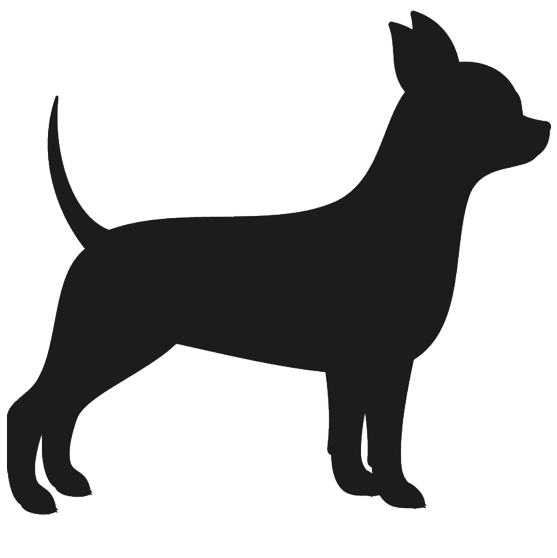

In [82]:
##https://github.com/jess-data/Twitter-2020-Sentiment-Analysis/blob/master/Twitter%20Sentiment%20Analysis%20Project.ipynb
#It's now time to create the wordcloud
#import an image for the word cloud as a numpy array to make sure it works
dog_mask = np.array(Image.open("dog_mask.png"))
fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(12) # set width
fig.set_figheight(10) # set height

plt.imshow(dog_mask, cmap=plt.cm.gray, interpolation='bilinear') # Display data as an image
plt.axis('off') # Remove axis
plt.show() # Display image

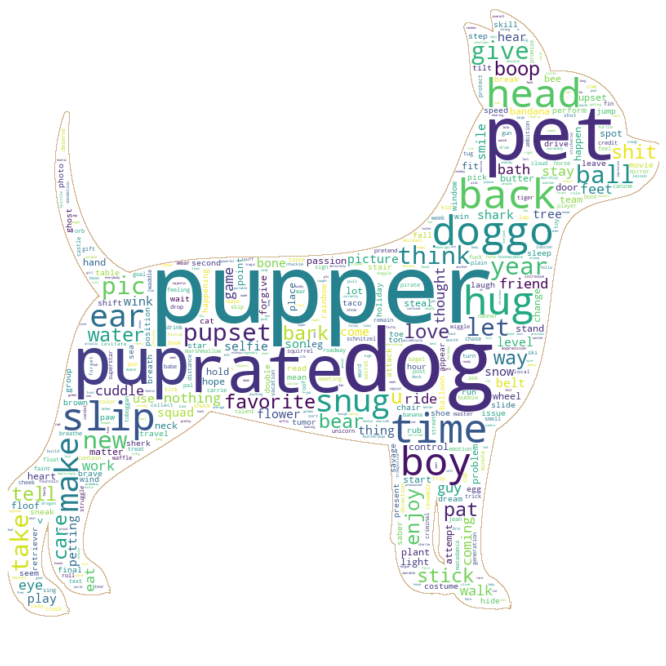

In [83]:
#Combine all valid words into one big text
text3 = " ".join(review for review in df_words.Words)
# Create a word cloud image
WeRateDogs_wc = WordCloud(background_color="white", 
                          max_words=500, mask=dog_mask,
                          stopwords=stoplist, 
                          contour_width=1, contour_color='tan')

# Generate a wordcloud
WeRateDogs_wc.generate(text3)

# show
plt.figure(figsize=[14,12])
plt.imshow(WeRateDogs_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [84]:
#Save the words dataaframe to a csv file for use in tableau
df_words.to_csv('twitter_words.csv', index=False)

### Insights:
1. The higher the number of likes a tweet has the higher the number of retweets. In this dataset, the most liked tweet is the most retweeted too!

2. The breed **Golden Retriever** has the highest likes, retweets and rating numerator

3. December has the highest number of tweets posted and retweeted, while more likes were recorded in August.

4. The most 5 most popular words in at WeRateDogs are pupper, dog, pet, dogs and pup. 

5. The puppo stage is the most liked and had the highest average favorite count.

### Visualization

This visualization was created in tableau and embedded in this notebook.

In [1]:
%%HTML
<div class='tableauPlaceholder' id='viz1662569604404' style='position: relative'><noscript><a href='#'><img alt='WERATEDOGS VISUALIZATION DASHBOARD ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;We&#47;WeRateDogsVisualization&#47;WERATEDOGSVISUALIZATIONDASHBOARD_1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='WeRateDogsVisualization&#47;WERATEDOGSVISUALIZATIONDASHBOARD_1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;We&#47;WeRateDogsVisualization&#47;WERATEDOGSVISUALIZATIONDASHBOARD_1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1662569604404');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='2327px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Data Used for Analysis and Visualization

The combined dataframe saved as `twitter_archive_master.csv` was used to create all the visualizations. In addition, I created a dataframe (df_words) containing tokenized words and their frequencies in order to create the wordcloud and check for word frequencies.

### Limitations

1. A visual assessment of a few `jpg_url` shows that some of the predictions captured as False actually contain dog images. This data was not used in the analysis 

### References

https://docs.tweepy.org/en/stable/

https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

https://stackoverflow.com/questions/47925828/how-to-create-a-pandas-dataframe-using-tweepy